In [1]:
import sqlite3
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the embedding data from the unshuffled sequences
# ids are in ruseq.txt
conn = sqlite3.connect('../uniref90-10pm.db')
c = conn.cursor()

# get the embeddings
embeddings_unshuff = []
with open('ruseq.txt') as f:
    keys = f.read().splitlines()

for key in keys:
    c.execute('SELECT embedding FROM uniref90 WHERE name = ?', (key,))
    embedding = c.fetchone()[0]
    if np.frombuffer(embedding, dtype=np.float16).shape[0] != 1024:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float32))
    else:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float16))

conn.close()

In [3]:
embeddings_unshuff = np.array(embeddings_unshuff)

In [4]:
# load the shuffled sequences
# embedding data is in rss.h5

embeddings_shuff = []

with h5py.File('rss.h5', 'r') as f:
    for key in f.keys():
        embeddings_shuff.append(f[key][:])

print(np.array(embeddings_shuff).shape)
embeddings_shuff = np.array(embeddings_shuff)

(1000, 1024)


In [5]:
import pandas as pd

# read third party embeddings from the tsv file
df = pd.read_csv('../rg/filtered_data.tsv', sep='\t')
df1 = pd.read_csv('../rg/filtered_data1.tsv', sep='\t')

# get the euclid sim and cosine sim from the columns
euclid_sim = df['embdd_eucld'].values
cos_sim = df['embdd_cos'].values
euclid_sim1 = df1['embdd_eucld'].values
cos_sim1 = df1['embdd_cos'].values

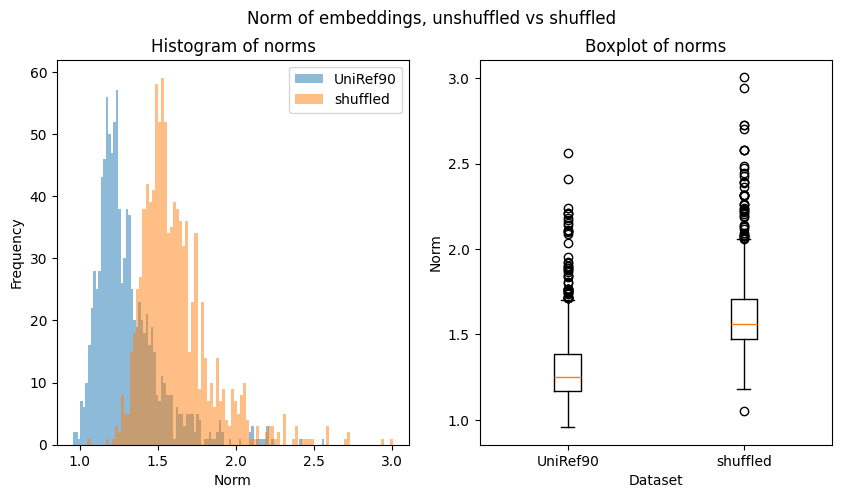

: 

In [6]:
# plot the norms of the embeddings on a histogram and a boxplot on the same plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plt.suptitle('Norm of embeddings, unshuffled vs shuffled')
ax[0].hist(np.linalg.norm(embeddings_unshuff, axis=1), bins=100, alpha=0.5, label='UniRef90')
ax[0].hist(np.linalg.norm(embeddings_shuff, axis=1), bins=100, alpha=0.5, label='shuffled')
ax[0].set_title('Histogram of norms')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Norm')
ax[0].legend()

ax[1].boxplot([np.linalg.norm(embeddings_unshuff, axis=1), np.linalg.norm(embeddings_shuff, axis=1)], labels=['UniRef90', 'shuffled'])
ax[1].set_title('Boxplot of norms')
ax[1].set_ylabel('Norm')
ax[1].set_xlabel('Dataset')

plt.show()

In [21]:
# plot histograms of the embeddings euclidean similarities for unshuff - unshuff pairs and unshuff - shuff pairs
# euclidean sim is 0.5 / (0.5 + euclidean distance)

from scipy.spatial.distance import euclidean
import tqdm as tqdm

def euclidean_sim(a, b):
    return 0.5 / (0.5 + euclidean(a, b))

# unshuff - unshuff
sims_unshuff = []
sims_shuff = []
for i in tqdm.tqdm(range(embeddings_unshuff.shape[0]), total=embeddings_unshuff.shape[0]):
    for j in range(i+1, embeddings_unshuff.shape[0]):
        sims_unshuff.append(euclidean_sim(embeddings_unshuff[i], embeddings_unshuff[j]))
        sims_shuff.append(euclidean_sim(embeddings_unshuff[i], embeddings_shuff[j]))

# plt.hist(sims_unshuff, bins=100, alpha=0.5, label='unshuff - unshuff')
# plt.hist(sims_shuff, bins=100, alpha=0.5, label='unshuff - shuff')
# plt.legend()
# plt.show()

100%|██████████| 1000/1000 [00:11<00:00, 90.64it/s]


In [22]:
# print unsuff - unshuff mean and std
print(np.mean(sims_unshuff), np.std(sims_unshuff))

0.2517409715442192 0.03342675720114167


In [23]:
# do a t-test to see if the two distributions are different

from scipy.stats import ttest_ind

t, p = ttest_ind(sims_unshuff, sims_shuff)
print(t, p)

677.3910436867375 0.0


In [24]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity as cosine

# unshuff - unshuff
sims_unshuff1 = []
sims_shuff1 = []
for i in tqdm.tqdm(range(embeddings_unshuff.shape[0]), total=embeddings_unshuff.shape[0]):
    for j in range(i+1, embeddings_unshuff.shape[0]):
        sims_unshuff1.append(cosine(embeddings_unshuff[i].reshape(1, -1), embeddings_unshuff[j].reshape(1, -1))[0][0])
        sims_shuff1.append(cosine(embeddings_unshuff[i].reshape(1, -1), embeddings_shuff[j].reshape(1, -1))[0][0])

# plt.hist(sims_unshuff1, bins=100, alpha=0.5, label='unshuff - unshuff')
# plt.hist(sims_shuff1, bins=100, alpha=0.5, label='unshuff - shuff')
# plt.legend()
# plt.show()

100%|██████████| 1000/1000 [08:41<00:00,  1.92it/s]


499500


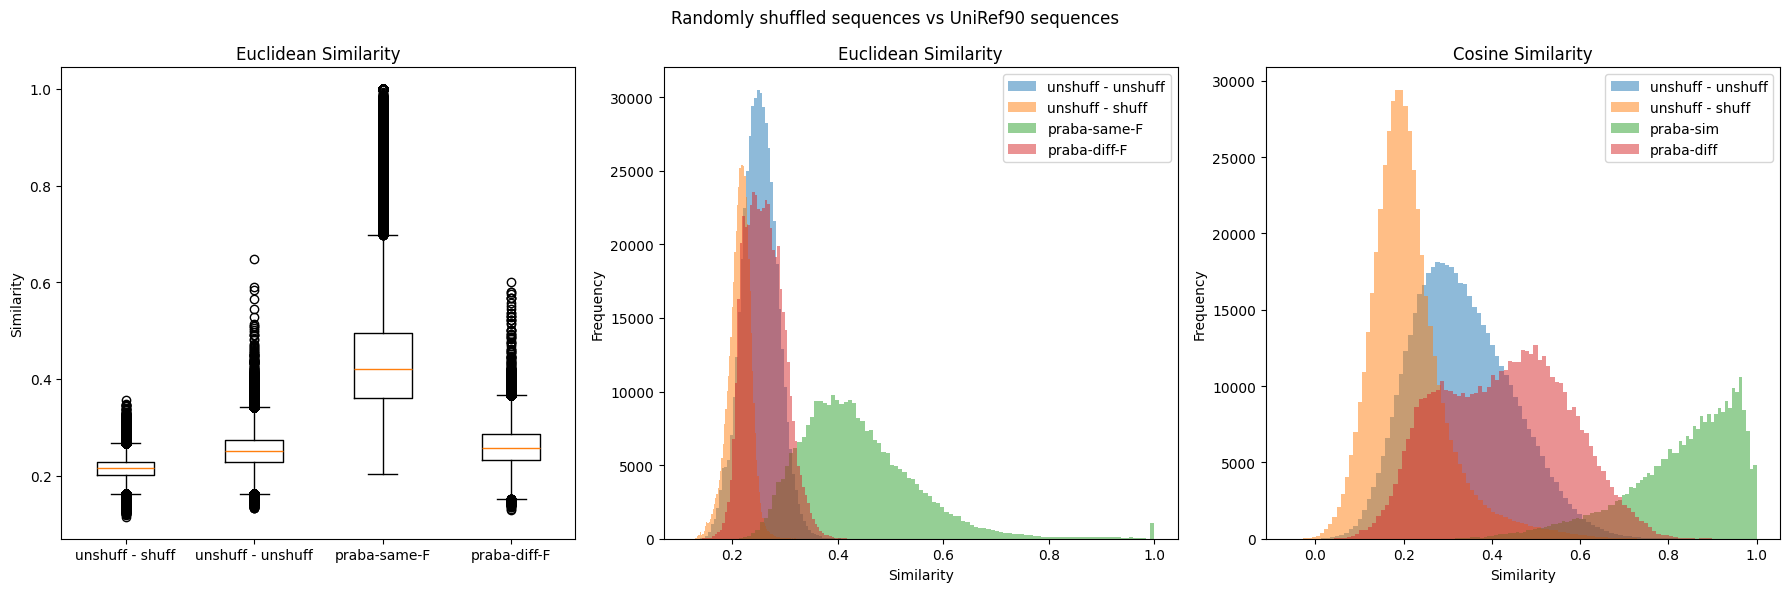

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create 1x3 subplots

fig.suptitle('Randomly shuffled sequences vs UniRef90 sequences')
print(len(sims_unshuff))

axs[0].boxplot([sims_shuff, sims_unshuff, euclid_sim, euclid_sim1], labels=['unshuff - shuff', 'unshuff - unshuff', 'praba-same-F', 'praba-diff-F'])
axs[0].set_title('Euclidean Similarity')
axs[0].set_ylabel('Similarity')

axs[1].hist(sims_unshuff, bins=100, alpha=0.5, label='unshuff - unshuff')
axs[1].hist(sims_shuff, bins=100, alpha=0.5, label='unshuff - shuff')
axs[1].hist(euclid_sim, bins=100, alpha=0.5, label='praba-same-F')
axs[1].hist(euclid_sim1, bins=100, alpha=0.5, label='praba-diff-F')
axs[1].set_title('Euclidean Similarity')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('Frequency')

axs[2].hist(sims_unshuff1, bins=100, alpha=0.5, label='unshuff - unshuff')
axs[2].hist(sims_shuff1, bins=100, alpha=0.5, label='unshuff - shuff')
axs[2].hist(cos_sim, bins=100, alpha=0.5, label='praba-sim')
axs[2].hist(cos_sim1, bins=100, alpha=0.5, label='praba-diff')
axs[2].set_title('Cosine Similarity')
axs[2].legend(loc='upper right')
axs[2].set_xlabel('Similarity')
axs[2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()